In [108]:
import glob
import xarray as xr
import numpy as np
import pandas as pd
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
import copy


In [48]:
def preprocess(data_set: xr.Dataset) -> xr.Dataset:
    """Preprocesses and xarray Dataset by subsetting to specific variables - to be used on read-in

    Args:
        ds (xr.Dataset): input Dataset

    Returns:
        xr.Dataset: output Dataset
    """

    data_vars = ["TLAI", "GPP", "TBOT", "RAIN", "SNOW", "area", "landfrac"]
    return data_set[data_vars]

def read_in_clm_sim(clm_dir: str):
    """Reads in CLM simulation needed to calculate Whittaker biomes

    Args:
        clm_dir (str): path to CLM simulation

    Returns:
        xr.Dataset: CLM simulation dataset
    """

    # load full grid CLM simulation at 2degree
    files = sorted(glob.glob(clm_dir + "*h0*"))[-84:]
    clm_sim = xr.open_mfdataset(
        files,
        combine="nested",
        concat_dim="time",
        parallel=True,
        preprocess=preprocess,
        decode_times=False,
    )
    clm_sim["time"] = xr.cftime_range("2007", periods=84, freq="MS", calendar="noleap")

    return clm_sim

def calculate_annual_mean(
    data_array: xr.DataArray, conversion_factor: float = 1 / 365
) -> xr.DataArray:
    """Calculates annual mean of an input DataArray, applies a conversion factor if supplied

    Args:
        da (xr.DataArray): input DataArray
        conversion_factor (float, optional): Conversion factor. Defaults to 1/365.

    Returns:
        xr.DataArray: output DataArray
    """

    months = data_array["time.daysinmonth"]
    annual_mean = conversion_factor * (months * data_array).groupby("time.year").sum()
    annual_mean.name = data_array.name
    return annual_mean

def get_global_vars(clm_sim: xr.Dataset, elev):
    """Reads in and processes data needed for Whittaker biome calculation

    Args:
        clm_dir (xr.Dataset): CLM simulation dataset

    Returns:
        xr.DataArray: temperature, precipitation, and gpp
    """

    # calculate biotemperature (<0 or >30 is zero)
    biotemp = clm_sim.TBOT - 273.15
    biotemp = xr.where(biotemp <= 0, 0, biotemp)
    biotemp = xr.where(biotemp >= 30, 0, biotemp)
    biotemp_annual = calculate_annual_mean(biotemp).mean(dim='year')
    biotemp_annual = biotemp_annual.to_dataset(name='biotemperature')

    temp = clm_sim.TBOT - 273.15
    # interpolation based on http://xarray.pydata.org/en/stable/interpolation.html
    # interpolation can't be done across the chunked dimension so we have to load it all into memory
    elev.load()
    # interpolate into resolution grid temperature
    interp_elev = elev.interp(lat=temp["lat"], lon=temp["lon"])

    temp_elev = xr.combine_by_coords([temp, interp_elev], coords=['lat', 'lon'], join="inner")
    temp_elev['sea_level_temp'] = temp_elev.TBOT + 6*(temp_elev.data/1000)
    temp_elev['sea_level_temp'] = xr.where(temp_elev['sea_level_temp'] <= 0, 0, temp_elev['sea_level_temp'])
    seatemp_annual = temp_elev.sea_level_temp.groupby('time.year').mean().mean(dim='year')
    seatemp = seatemp_annual.to_dataset(name='sealevel_temp')

    # precipitation
    conversion_factor = 24 * 60 * 60 * 365 / 10
    rain = conversion_factor * calculate_annual_mean(clm_sim.RAIN).mean(
        dim="year"
    )  # cm/yr
    snow = conversion_factor * calculate_annual_mean(clm_sim.SNOW).mean(
        dim="year"
    )  # cm/yr
    precip = rain + snow
    precip = precip.to_dataset(name='precipitation')

    ds = xr.merge([biotemp_annual, seatemp, precip])

    return ds

In [87]:
def get_euclid(i, clim_dat, holdridge_dat):
    
    pet_val = holdridge_dat['PET_ratio'].values[i]
    biotemp_val = holdridge_dat['biotemp'].values[i]
    precip_val = holdridge_dat['precip'].values[i]
    
    pet_dist = (pet_val - clim_dat['pet_rat'])**2
    temp_dist = (biotemp_val - clim_dat['biotemperature'])**2
    precip_dist = (precip_val - clim_dat['precipitation'])**2
    
    euclid = pet_dist + temp_dist + precip_dist
    
    return euclid

In [109]:
def plot_map(da, title, cbar_label, vmin, vmax, cmap):
    
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
    
    fig.suptitle(title, fontsize='large', fontweight='bold')

    ax.set_extent([-180, 180, -56, 85], crs=ccrs.PlateCarree())
    ax.coastlines()
    ocean = ax.add_feature(
            cfeature.NaturalEarthFeature('physical','ocean','110m', facecolor='white'))
    
    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,
                   transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap)
    cbar = fig.colorbar(im, ax=ax, pad=0.02, fraction = 0.03, orientation='horizontal')
    cbar.set_label(cbar_label,size=12,fontweight='bold')

In [6]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,                                     # The number of cores you want
    memory='25GB',                               # Amount of memory
    processes=1,                                 # How many processes
    queue='casper',                              # The type of queue to utilize
    local_directory='/glade/work/afoster',       # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB',   # Specify resources
    account='P93300041',                         # Input your project ID here
    walltime='02:00:00',                         # Amount of wall time
    interface='ext')

In [7]:
cluster.scale(2)
client = Client(cluster)

In [10]:
clm_sim_dir = '/glade/campaign/cgd/tss/people/oleson/PPE/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
clm_sim = read_in_clm_sim(clm_sim_dir)

In [34]:
elev = xr.open_dataset('/glade/u/home/afoster/holdridge/elev.1-deg.nc', decode_times=False)
elev = elev.isel(time=0)

In [81]:
annual_ds = get_global_vars(clm_sim, elev)

In [82]:
annual_ds['pet_rat'] = (annual_ds.biotemperature*58.93)/annual_ds.precipitation

In [64]:
sealevel_bins = [1.68, 3.36, 6.72, 13.44, 26.89]
annual_ds['sealevel_reg'] = xr.where(annual_ds['sealevel_temp'] <= sealevel_bins[0], 1, 0)
annual_ds['sealevel_reg'] = xr.where(annual_ds['sealevel_temp'] > sealevel_bins[0], 2, annual_ds['sealevel_reg'])
annual_ds['sealevel_reg'] = xr.where(annual_ds['sealevel_temp'] > sealevel_bins[1], 3, annual_ds['sealevel_reg'])
annual_ds['sealevel_reg'] = xr.where(annual_ds['sealevel_temp'] > sealevel_bins[2], 4, annual_ds['sealevel_reg'])
annual_ds['sealevel_reg'] = xr.where(annual_ds['sealevel_temp'] > sealevel_bins[3], 5, annual_ds['sealevel_reg'])
annual_ds['sealevel_reg'] = xr.where(annual_ds['sealevel_temp'] > sealevel_bins[4], 6, annual_ds['sealevel_reg'])
seatemp = annual_ds.where(annual_ds.sealevel_reg > 0).sealevel_temp
seatemp_region = annual_ds.where(annual_ds.sealevel_reg > 0).sealevel_reg

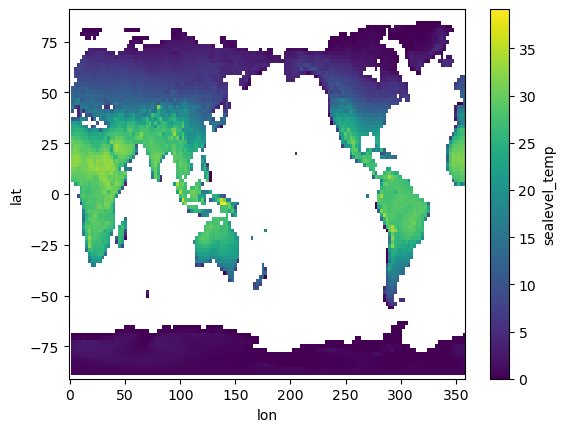

In [56]:
seatemp.plot()

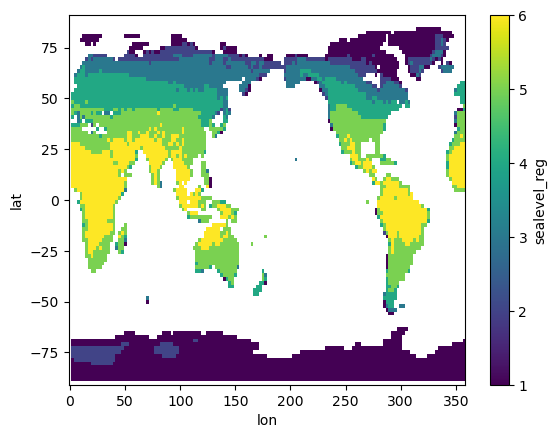

In [65]:
seatemp_region.plot()

In [67]:
anntemp_bins = [1.5, 3, 6, 12, 24]
annual_ds['reg'] = xr.where(annual_ds['biotemperature'] <= anntemp_bins[0], 1, 0)
annual_ds['reg'] = xr.where(annual_ds['biotemperature'] > anntemp_bins[0], 2, annual_ds['reg'])
annual_ds['reg'] = xr.where(annual_ds['biotemperature'] > anntemp_bins[1], 3, annual_ds['reg'])
annual_ds['reg'] = xr.where(annual_ds['biotemperature'] > anntemp_bins[2], 4, annual_ds['reg'])
annual_ds['reg'] = xr.where(annual_ds['biotemperature'] > anntemp_bins[3], 5, annual_ds['reg'])
annual_ds['reg'] = xr.where(annual_ds['biotemperature'] > anntemp_bins[4], 6, annual_ds['reg'])
anntemp = annual_ds.where(annual_ds.reg > 0).biotemperature
anntemp_reg = annual_ds.where(annual_ds.reg > 0).reg

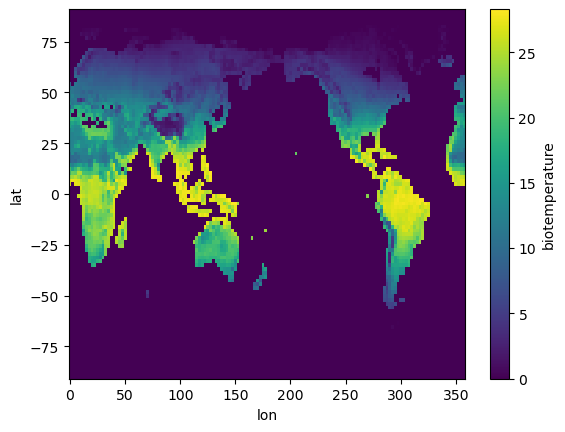

In [68]:
anntemp.plot()

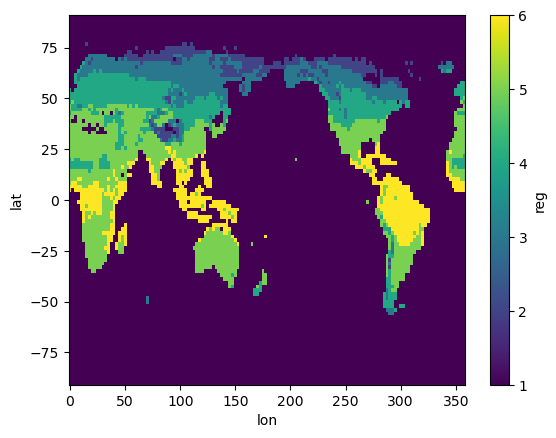

In [69]:
anntemp_reg.plot()

In [71]:
region_ds = xr.merge([anntemp, anntemp_reg, seatemp, seatemp_region])

In [77]:
region_ds['region_diff'] = region_ds.reg - region_ds.sealevel_reg
region_ds = region_ds.where(region_ds.region_diff <= 0)
region_ds['reg'] = xr.where(region_ds['region_diff'] == 0, 0, region_ds['reg'])

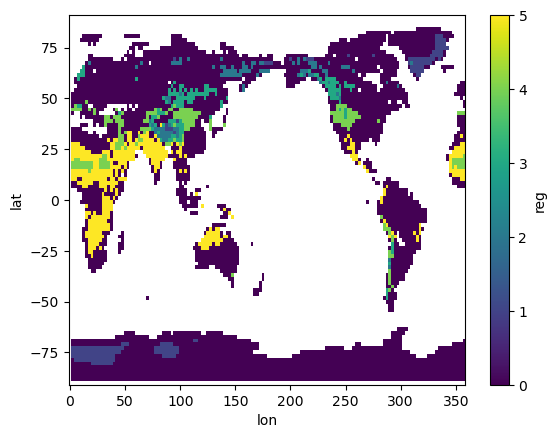

In [78]:
region_ds.reg.plot();

In [92]:
clim_dat = xr.merge([region_ds, annual_ds.pet_rat, annual_ds.precipitation])

In [86]:
## climate zone centroids
holdridge_dat = pd.read_csv('/glade/u/home/afoster/holdridge/holdridge_climates.csv')

In [97]:
## get all centroids
out = []
for i in range(33):
    euc = get_euclid(i, clim_dat, holdridge_dat)
    out.append(euc)
## concatenate
ds = xr.concat(out, 'zone', data_vars='all')
ds = ds.assign_coords(zone=("zone", np.arange(33)+1))
## get minimum euclidean distance (i.e. best fit zone)
zones = ds.idxmin(dim='zone', skipna=True)

In [98]:
clim_dat_zones = xr.merge([zones, clim_dat])

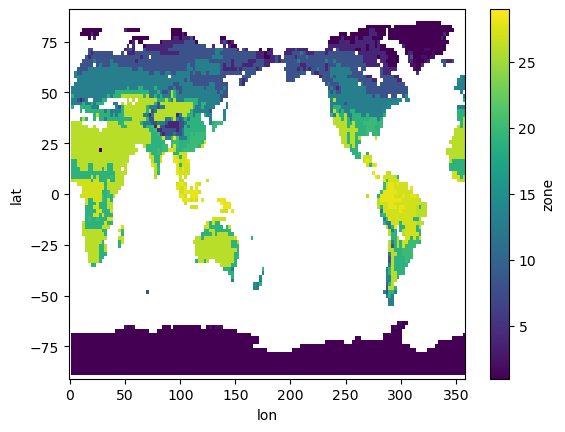

In [100]:
clim_dat_zones.zone.plot()

In [105]:
cols = holdridge_dat.color.values
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", cols)

NameError: name 'cbar_label' is not defined

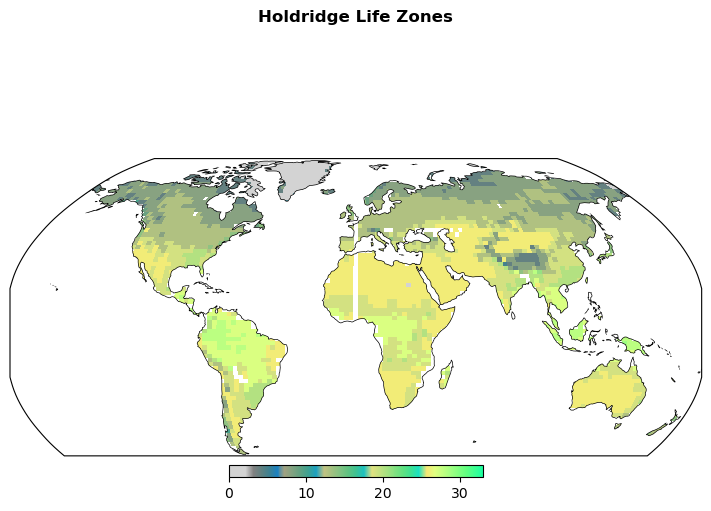

In [117]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
fig.suptitle('Holdridge Life Zones', fontsize='large', fontweight='bold')
ax.set_extent([-180, 180, -56, 85], crs=ccrs.PlateCarree())
ax.coastlines()
ocean = ax.add_feature(
        cfeature.NaturalEarthFeature('physical', 'ocean', '110m', facecolor='white'))
im = ax.pcolormesh(clim_dat_zones.lon, clim_dat_zones.lat, clim_dat_zones.zone,
               transform=ccrs.PlateCarree(), vmin=0, vmax=33, cmap=cmap)
cbar = fig.colorbar(im, ax=ax, pad=0.02, fraction = 0.03, orientation='horizontal')
#cbar.set_label(cbar_label, size=12, fontweight='bold')